## Download and Read Data

In [1]:
import pandas as pd
housing = pd.read_csv('housing.csv')

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Checking for null values and data types of the features

In [41]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [42]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Checking for numerical attributes of the features

In [44]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Creating Histograms of the features

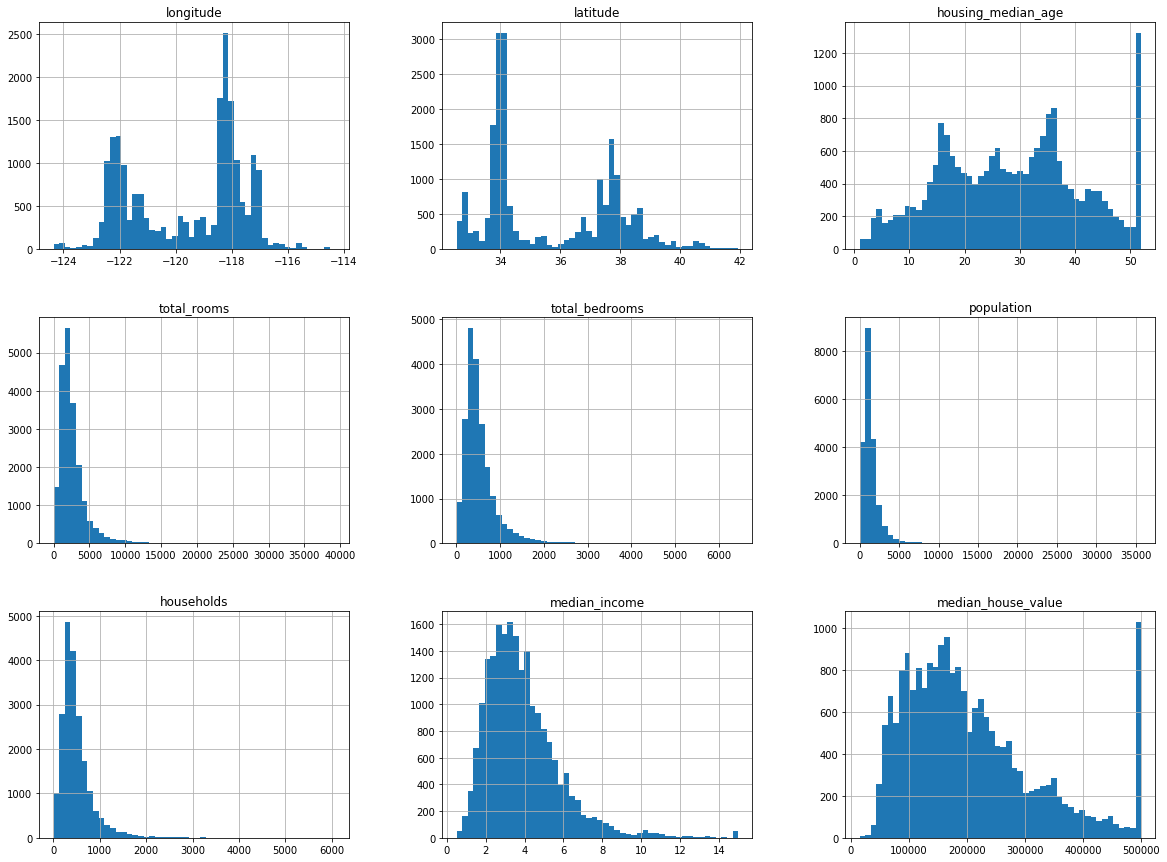

In [45]:
%matplotlib inline

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

From the graph, there are a few things that can be concluded:
1. it's obvious that the median income attribute is not expressed in USD and it has been scaled and capped at around 15 for higher median income, and at 0.5 for lower median income. (in tens of thousands of dollars)

2. Housing median age and the median house value were also capped. Since median house value is the target variable it may cause the prediction prices to never go beyond the limit.


## Creating test and train sets

In [55]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42) #set random seed so the test set generated is always the same(make sure the ml does not get to see the whole dataset after multiple runs)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * (test_ratio))
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [56]:
train_set, test_set = split_train_test(housing,0.2)

In [57]:
len(train_set)

16512

In [58]:
len(test_set)

4128

In [59]:
from zlib import crc32

In [64]:
#split train and test set using ids(to avoid generating diff test sets)
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [65]:
#creating ids for the housing data(add index to column)
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [66]:
housing_with_id['id'] = housing['longitude'] * 100 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [67]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

## Check whether test_set is representative of various categories of incomes in the dataset

Create an income category attribute between 1.5- 6 (since most data points are clustered around the two) and histogram for it to check.

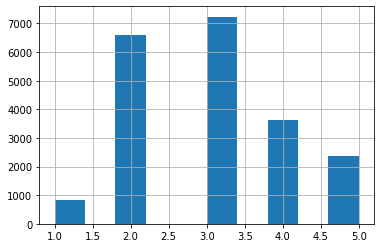

In [68]:
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins=[0, 1.5, 3.0, 4.5, 6., np.inf],
                              labels = [1, 2, 3, 4, 5])
housing['income_cat'].hist()

# Use stratified sampling to eliminate possible sampling bias

In [72]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [74]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

The data shows that the weight of each income category are stratified accordingly to their quantity in the dataset. (e.g. category 3 (i.e. 3 to 4.5) has the most data so the weight is highest (i.e. 0.35))

In [76]:
# now remove the income_cat feature 

for set_ in(strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [80]:
#creating a copy of the data to visualize without affecting original dataset
housing = strat_train_set.copy()

# Visualize data using geographical information

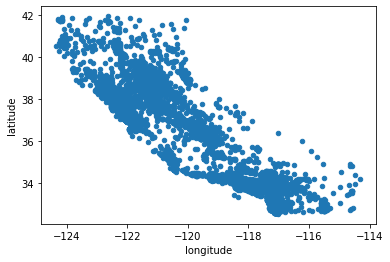

In [78]:
housing.plot(kind='scatter', x='longitude', y='latitude')

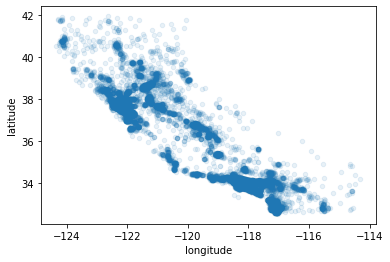

In [79]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

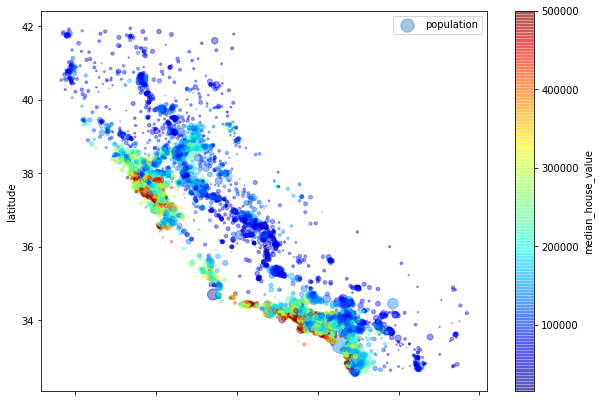

In [81]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', figsize=(10,7),
            c = 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,)
plt.legend()

## Exploring Correlations of the Features

In [82]:
corr_matrix = housing.corr()

In [83]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

## Plotting Correlation Matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba18300b90>,
      dtype=object)

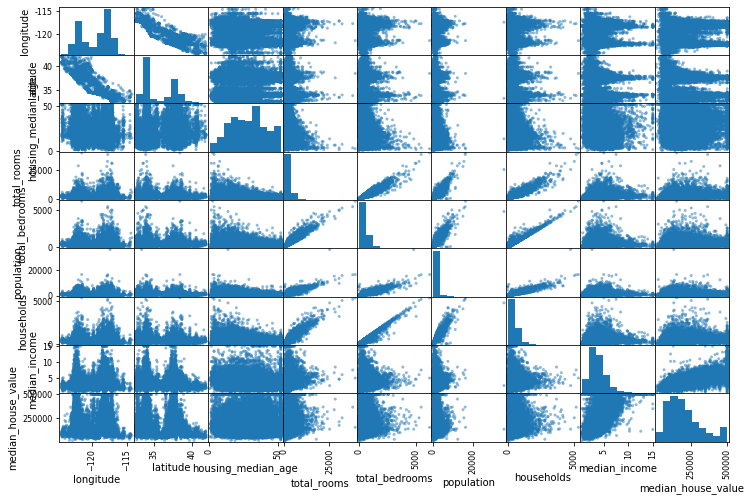

In [87]:
from pandas.plotting import scatter_matrix

# attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

# scatter_matrix(housing[attributes], figsize=(12,8))
scatter_matrix(housing, figsize=(12,8))

From the graph, it'd seem that the median income feature would be the best predictor for median house value.

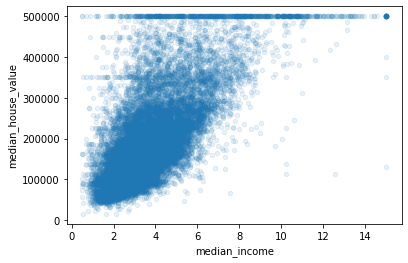

In [86]:
housing.plot(kind='scatter', x='median_income', y='median_house_value',
            alpha=0.1)

## Features exploration

In predicting the 'median house value', features such as 'number of rooms per household', 
'bedroom to total room ratio', and 'population per household' would be helpful to know.

In [88]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']


In [89]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

It seems like having more rooms per household would increase its value which makes sense that bigger houses are more expensive. Another attribute is that having lower bedroom to room ratio decreases the value of the houses.

## Data Preping for Training and Testing Model

In [90]:
#Drop and separate the target variable
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Data Cleaning

In [92]:
# housing.dropna(subset=['total_bedrooms'])
# housing.drop('total_bedrooms', axis=1)
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

Using imputer to impute median

In [94]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

#Drop non numerical attribute
housing_num = housing.drop('ocean_proximity', axis=1)

In [95]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [96]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [97]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform data using trained imputer

In [98]:
#replace missing values with learned medians
X = imputer.transform(housing_num)

In [99]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index=housing_num.index)

## Handling text/categorical data

In [101]:
housing_cat = housing[['ocean_proximity']]

In [104]:
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [105]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [106]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [109]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [111]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [112]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# If Using Customizing Transformers

In [114]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6,

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else: 
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values) #added rooms_per_household, population_per_household

## Using a Transformation Pipelines

In [138]:
from  sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [139]:
housing_num_tr[0]

array([-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
        0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
       -0.12112176])

## Using Column Transformer to combine and transform all features

In [143]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
print(num_attribs)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [145]:
housing_prepared[0]

array([-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
        0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
       -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ])

## Model training and selection

# Linear Regression

In [148]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [149]:
sample_data = housing.iloc[:5]
sample_labels = housing_labels.iloc[:5]
sample_data_prepared = full_pipeline.transform(sample_data)
print('Predictions:', lin_reg.predict(sample_data_prepared))
print('Labels:', list(sample_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


Performance Metrics

In [152]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

# Decision Tree

In [151]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [153]:
housing_predictions_tree = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Cross Validation

In [154]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)

tree_rmse_scores = np.sqrt(-scores)

In [155]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [72251.22610062 70811.34799853 68000.08591434 71929.39104752
 69328.61392367 77963.99482744 71628.79228943 73511.78648072
 69045.58722762 69854.4073967 ]
Mean: 71432.52332065887
Standard deviation: 2696.6824522410743


In [156]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180675


# Random Forest Regressor

In [188]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions_fr = forest_reg.predict(housing_prepared)
forest_reg_mse = mean_squared_error(housing_labels, housing_predictions_fr)
forest_reg_rmse = np.sqrt(forest_reg_mse)
forest_reg_rmse

18665.926961011453

In [164]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [51462.1870592  49255.26360643 46707.97710377 52280.08251618
 47419.99672025 52088.38436042 52669.58889715 50082.76022169
 48434.02352828 53710.91356241]
Mean: 50411.1177575786
Standard deviation: 2267.4461027335283


In [189]:
from sklearn.svm import SVR

svr_reg = SVR(kernel='linear')
svr_reg.fit(housing_prepared, housing_labels)

housing_predictions_svr = svr_reg.predict(housing_prepared)
svr_reg_mse = mean_squared_error(housing_labels, housing_predictions_svr)
svr_reg_rmse = np.sqrt(svr_reg_mse)
svr_reg_rmse

111095.06635291966

In [191]:
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
Mean: 111814.1069260169
Standard deviation: 2600.840269089257


In [193]:
from sklearn.svm import SVR

svrrbf_reg = SVR(kernel='rbf')
svrrbf_reg.fit(housing_prepared, housing_labels)

housing_predictions_svrrbf = svrrbf_reg.predict(housing_prepared)
svrrbf_reg_mse = mean_squared_error(housing_labels, housing_predictions_svrrbf)
svrrbf_reg_rmse = np.sqrt(svrrbf_reg_mse)
svrrbf_reg_rmse

118578.69234925653

In [194]:
svrrbf_scores = cross_val_score(svrrbf_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

svrrbf_rmse_scores = np.sqrt(-svrrbf_scores)
display_scores(svrrbf_rmse_scores)

Scores: [116729.13778306 120113.99351281 113925.04340616 120399.11878641
 114687.49942071 122785.64737282 119853.79338279 118280.31108193
 120230.82615529 118840.1885232 ]
Mean: 118584.55594251942
Standard deviation: 2609.6120823493407


## Saving Model and Loading Model

In [165]:
import joblib

joblib.dump(forest_reg,'housing_fr_model.pkl')

['housing_fr_model.pkl']

In [166]:
model_ld = joblib.load('housing_fr_model.pkl')

# Fine Tuning Model

In [173]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [174]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True)

In [175]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [176]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [178]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [179]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63514.277976810896 {'max_features': 2, 'n_estimators': 3}
54995.82960815886 {'max_features': 2, 'n_estimators': 10}
52518.92968710903 {'max_features': 2, 'n_estimators': 30}
60469.156575828136 {'max_features': 4, 'n_estimators': 3}
53210.44041946439 {'max_features': 4, 'n_estimators': 10}
50522.20260955228 {'max_features': 4, 'n_estimators': 30}
58949.317313659754 {'max_features': 6, 'n_estimators': 3}
52632.96958150966 {'max_features': 6, 'n_estimators': 10}
49921.51133144082 {'max_features': 6, 'n_estimators': 30}
58615.848261877705 {'max_features': 8, 'n_estimators': 3}
52241.902591322985 {'max_features': 8, 'n_estimators': 10}
49937.21512902723 {'max_features': 8, 'n_estimators': 30}
62405.19930655836 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54100.85735850802 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60634.22275497 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52323.43832011864 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [180]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [181]:
feature_importances

array([7.90700190e-02, 6.75615295e-02, 3.95995141e-02, 1.72490543e-02,
       1.70210355e-02, 1.80448695e-02, 1.72912020e-02, 3.56153751e-01,
       5.56713368e-02, 1.04166989e-01, 6.23671871e-02, 1.25773724e-02,
       1.44532185e-01, 1.23413906e-04, 3.50699927e-03, 5.06354187e-03])

In [182]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3561537506079658, 'median_income'),
 (0.14453218514628843, 'INLAND'),
 (0.10416698902910017, 'pop_per_hhold'),
 (0.07907001895904449, 'longitude'),
 (0.06756152954897982, 'latitude'),
 (0.06236718710732416, 'bedrooms_per_room'),
 (0.05567133676763937, 'rooms_per_hhold'),
 (0.03959951411028107, 'housing_median_age'),
 (0.01804486946592441, 'population'),
 (0.017291202043014195, 'households'),
 (0.017249054280402187, 'total_rooms'),
 (0.017021035458676396, 'total_bedrooms'),
 (0.012577372424768167, '<1H OCEAN'),
 (0.005063541874538573, 'NEAR OCEAN'),
 (0.003506999269995303, 'NEAR BAY'),
 (0.000123413906057429, 'ISLAND')]

## Evaluating System on Test Set

In [183]:
final_model = grid_search.best_estimator_

In [184]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [185]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [186]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) **2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

array([46157.49275376, 50088.78675701])